In [76]:
# import necessary libraries
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision import datasets
from torchvision import transforms
import torch.optim as optim
import os

In [77]:
# set batch size and image size to 32 for quick training
batch_size = 32
img_size = 32
data_dir = 'dataset/' # our directory containing our image dataset

# Apply the transformations
transform = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()])

# Load the dataset from 
met_data = datasets.ImageFolder(data_dir, transform=transform)

# Load the met data into a dataloader
met_img_loader = torch.utils.data.DataLoader(met_data, batch_size, shuffle=True)

In [78]:
# scales image pixel values between -1 and 1
def scale(img, feature_range=(-1, 1)):
    min_, max_ = feature_range
    img = img * (max_ - min_) + min_
    return img

In [79]:
# helper conv function, creates a convolutional layer for the Discriminator
def conv(input_channels, output_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    
    layers = []
    conv_layer = nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding, bias=False)
    
    # Adding the created convolutional layer
    layers.append(conv_layer)
    
    # Apply batch normalization if necessary
    if batch_norm:
        layers.append(nn.BatchNorm2d(output_channels))
        
    # returning the sequential container
    return nn.Sequential(*layers)

In [80]:
# Discriminator Class
class Discriminator(nn.Module):

    # initialize Discriminator with given dimension of 1st convolutional layer
    def __init__(self, conv_dim):
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim
        # adds 4 layers using the conv function
        self.cv1 = conv(3, self.conv_dim, 4, batch_norm=False)
        self.cv2 = conv(self.conv_dim, self.conv_dim * 2, 4, batch_norm=True)
        self.cv3 = conv(self.conv_dim * 2, self.conv_dim * 4, 4, batch_norm=True)
        self.cv4 = conv(self.conv_dim * 4, self.conv_dim * 8, 4, batch_norm=True)
        # Fully connected Layer
        self.fc1 = nn.Linear(self.conv_dim * 8 * 2 * 2, 1)

    def forward(self, x):
        # After passing through each layer
        # Applying leaky relu activation function
        x = F.leaky_relu(self.cv1(x), 0.2)
        x = F.leaky_relu(self.cv2(x), 0.2)
        x = F.leaky_relu(self.cv3(x), 0.2)
        x = F.leaky_relu(self.cv4(x), 0.2)
        # To pass throught he fully connected layer
        # We need to flatten the image first
        x = x.view(-1, self.conv_dim * 8 * 2 * 2)
        # Now passing through fully-connected layer
        x = self.fc1(x)
        # returns Discriminator's evaluation of whether the images are real or fake
        return x

In [81]:
# Generator helper deconv function, creates a transpose-convolution layer
def deconv(input_channels, output_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    
    layers = []
    convt_layer = nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding, bias=False)

    # Appending the layer created
    layers.append(convt_layer)

    if batch_norm:
        # Apply batch normalization if necessary
        layers.append(nn.BatchNorm2d(output_channels))

    # Returning the sequential container
    return nn.Sequential(*layers)

In [82]:
# Generator Class
class Generator(nn.Module):

    # initialize with the given random noise vector size and output layer dimension
    def __init__(self, z_size, conv_dim):
        super(Generator, self).__init__()

        self.z_size = z_size

        self.conv_dim = conv_dim

        # fully-connected-layer
        self.fc = nn.Linear(z_size, self.conv_dim * 8 * 2 * 2)
        # Adds 4 deconvolution layers using deconv helper function
        self.dcv1 = deconv(self.conv_dim * 8, self.conv_dim * 4, 4, batch_norm=True)
        self.dcv2 = deconv(self.conv_dim * 4, self.conv_dim * 2, 4, batch_norm=True)
        self.dcv3 = deconv(self.conv_dim * 2, self.conv_dim, 4, batch_norm=True)
        self.dcv4 = deconv(self.conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        # Passing through fully connected layer
        x = self.fc(x)
        
        # Changing the dimension
        x = x.view(-1, self.conv_dim * 8, 2, 2)
        
        # Passing through deconv layers
        # Applying the ReLu activation function
        x = F.relu(self.dcv1(x))
        x = F.relu(self.dcv2(x))
        x = F.relu(self.dcv3(x))
        x = torch.tanh(self.dcv4(x))
        # returning a conv_dim x conv_dim tensor image
        return x

In [83]:
# initialize weights to help model converge more quickly
def weights_init_normal(m):
    
    classname = m.__class__.__name__
    
    # For the linear layers
    if 'Linear' in classname:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        m.bias.data.fill_(0.01)
        
    # For the convolutional layers
    if 'Conv' in classname or 'BatchNorm2d' in classname:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)

In [99]:
# Setting dimensions for the Discriminator and Generator, should be the same value
d_conv_dim = 32
g_conv_dim = 32

# set size of noise vector for Generator
z_size = 100  

# initialize the Discriminator and Generator with given dimension sizes
D = Discriminator(d_conv_dim)
G = Generator(z_size=z_size, conv_dim=g_conv_dim)

# Applying the weight initialization
D.apply(weights_init_normal)
G.apply(weights_init_normal)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (dcv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dcv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dcv3): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dcv4): Sequential(
    (0): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)

In [85]:
# Calculates how close Discriminator Outputs are to evaluating the images as real
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

# Calculates how close Discriminator Outputs are to evaluating images as fake
def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [86]:
# Set hyperparameters for our optimizers
lr = 0.0004
beta1 = 0.3
beta2 = 0.999

# Using Adam optimizer with the given hyperparameters to help train the networks
d_optimizer = optim.Adam(D.parameters(), lr, betas=(beta1, beta2))
g_optimizer = optim.Adam(G.parameters(), lr, betas=(beta1, beta2))

In [87]:
# trains the Discriminator and Generator for the given number of epochs
def train(D, G, n_epochs, print_every=100):
    # param, D: the discriminator network
    # param, G: the generator network
    # param, n_epochs: number of epochs to train for
    # param, print_every: when to print and record the models' losses
    # return: D and G losses

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size = 32
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(met_img_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # Train the discriminator on real and fake images
            d_optimizer.zero_grad()

            # create Discriminator with real images
            dreal = D(real_images)
            dreal_loss = real_loss(dreal)

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)

            # loss of fake images
            dfake = D(fake_images)
            dfake_loss = fake_loss(dfake)

            # Adding both losses
            d_loss = dreal_loss + dfake_loss
            
            # Backpropogation step
            d_loss.backward()
            d_optimizer.step()

            # Train the generator with adversarial loss
            g_optimizer.zero_grad()

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)

            # Compute the discriminator losses on fake images
            D_fake = D(fake_images)
            # use real loss to flip labels
            g_loss = real_loss(D_fake, True)  

            # perform backpropagation
            g_loss.backward()
            g_optimizer.step()

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch + 1, n_epochs, d_loss.item(), g_loss.item()))

        ## AFTER EACH EPOCH##
        # generating samples
        G.eval()
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train()  # back to training

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)

    # return losses
    return losses

In [88]:
# set number of epochs
n_epochs = 500

# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  500] | d_loss: 1.3843 | g_loss: 0.6903
Epoch [    2/  500] | d_loss: 0.6653 | g_loss: 1.1710
Epoch [    3/  500] | d_loss: 0.2474 | g_loss: 1.9502
Epoch [    4/  500] | d_loss: 0.1073 | g_loss: 2.6777
Epoch [    5/  500] | d_loss: 0.1822 | g_loss: 2.4778
Epoch [    6/  500] | d_loss: 0.4042 | g_loss: 2.1911
Epoch [    7/  500] | d_loss: 1.0082 | g_loss: 0.8018
Epoch [    8/  500] | d_loss: 0.4810 | g_loss: 1.9608
Epoch [    9/  500] | d_loss: 1.0874 | g_loss: 1.1654
Epoch [   10/  500] | d_loss: 0.5685 | g_loss: 2.1464
Epoch [   11/  500] | d_loss: 0.7216 | g_loss: 2.1646
Epoch [   12/  500] | d_loss: 0.8083 | g_loss: 2.0932
Epoch [   13/  500] | d_loss: 1.1071 | g_loss: 1.3031
Epoch [   14/  500] | d_loss: 0.8316 | g_loss: 1.1908
Epoch [   15/  500] | d_loss: 1.1510 | g_loss: 2.0571
Epoch [   16/  500] | d_loss: 1.0689 | g_loss: 2.1096
Epoch [   17/  500] | d_loss: 0.7002 | g_loss: 1.5106
Epoch [   18/  500] | d_loss: 1.0980 | g_loss: 2.5163
Epoch [   19/  500] | d_loss

Epoch [  153/  500] | d_loss: 0.0429 | g_loss: 5.3552
Epoch [  154/  500] | d_loss: 0.0428 | g_loss: 10.2483
Epoch [  155/  500] | d_loss: 0.1846 | g_loss: 6.0513
Epoch [  156/  500] | d_loss: 0.6037 | g_loss: 7.8049
Epoch [  157/  500] | d_loss: 0.0340 | g_loss: 7.1597
Epoch [  158/  500] | d_loss: 0.0600 | g_loss: 6.0259
Epoch [  159/  500] | d_loss: 0.2542 | g_loss: 5.7113
Epoch [  160/  500] | d_loss: 0.0745 | g_loss: 5.8296
Epoch [  161/  500] | d_loss: 0.0213 | g_loss: 5.2343
Epoch [  162/  500] | d_loss: 0.1025 | g_loss: 4.7141
Epoch [  163/  500] | d_loss: 0.0893 | g_loss: 9.6806
Epoch [  164/  500] | d_loss: 0.2422 | g_loss: 8.6648
Epoch [  165/  500] | d_loss: 2.0356 | g_loss: 12.8855
Epoch [  166/  500] | d_loss: 0.0117 | g_loss: 5.1117
Epoch [  167/  500] | d_loss: 0.0033 | g_loss: 5.5689
Epoch [  168/  500] | d_loss: 0.1454 | g_loss: 4.6280
Epoch [  169/  500] | d_loss: 0.0191 | g_loss: 4.1301
Epoch [  170/  500] | d_loss: 0.0401 | g_loss: 4.4386
Epoch [  171/  500] | d_lo

Epoch [  305/  500] | d_loss: 0.0270 | g_loss: 7.8749
Epoch [  306/  500] | d_loss: 0.0441 | g_loss: 4.7905
Epoch [  307/  500] | d_loss: 0.2621 | g_loss: 5.0730
Epoch [  308/  500] | d_loss: 0.0386 | g_loss: 4.4215
Epoch [  309/  500] | d_loss: 1.1632 | g_loss: 14.4657
Epoch [  310/  500] | d_loss: 0.0397 | g_loss: 7.5399
Epoch [  311/  500] | d_loss: 0.0502 | g_loss: 2.9498
Epoch [  312/  500] | d_loss: 0.3442 | g_loss: 11.3484
Epoch [  313/  500] | d_loss: 0.1614 | g_loss: 9.8421
Epoch [  314/  500] | d_loss: 0.0108 | g_loss: 6.2377
Epoch [  315/  500] | d_loss: 0.0310 | g_loss: 4.4733
Epoch [  316/  500] | d_loss: 0.0171 | g_loss: 7.1442
Epoch [  317/  500] | d_loss: 0.1530 | g_loss: 4.8891
Epoch [  318/  500] | d_loss: 0.0145 | g_loss: 3.0374
Epoch [  319/  500] | d_loss: 0.1122 | g_loss: 7.0163
Epoch [  320/  500] | d_loss: 3.1388 | g_loss: 13.3417
Epoch [  321/  500] | d_loss: 0.4925 | g_loss: 12.4687
Epoch [  322/  500] | d_loss: 0.0526 | g_loss: 6.9095
Epoch [  323/  500] | d_

Epoch [  457/  500] | d_loss: 0.0042 | g_loss: 5.8808
Epoch [  458/  500] | d_loss: 0.0171 | g_loss: 5.7187
Epoch [  459/  500] | d_loss: 0.0072 | g_loss: 4.4290
Epoch [  460/  500] | d_loss: 0.0196 | g_loss: 6.5196
Epoch [  461/  500] | d_loss: 0.0026 | g_loss: 6.2785
Epoch [  462/  500] | d_loss: 0.0238 | g_loss: 3.9834
Epoch [  463/  500] | d_loss: 0.0108 | g_loss: 6.2227
Epoch [  464/  500] | d_loss: 0.0117 | g_loss: 5.8729
Epoch [  465/  500] | d_loss: 0.0075 | g_loss: 5.2555
Epoch [  466/  500] | d_loss: 0.0317 | g_loss: 5.7258
Epoch [  467/  500] | d_loss: 0.0102 | g_loss: 6.1261
Epoch [  468/  500] | d_loss: 0.0177 | g_loss: 5.5600
Epoch [  469/  500] | d_loss: 0.0053 | g_loss: 7.2682
Epoch [  470/  500] | d_loss: 0.0011 | g_loss: 16.6226
Epoch [  471/  500] | d_loss: 0.1810 | g_loss: 9.1655
Epoch [  472/  500] | d_loss: 0.7490 | g_loss: 14.2333
Epoch [  473/  500] | d_loss: 0.0000 | g_loss: 7.8323
Epoch [  474/  500] | d_loss: 0.8341 | g_loss: 13.4611
Epoch [  475/  500] | d_l

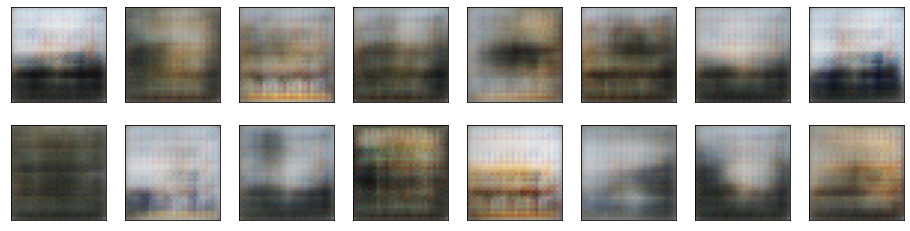

In [97]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1) * 255 / 2).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.imshow(img.reshape((32,32,3)))

# open generated images stored in the pickle file
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
    
# change the '-1' to another epoch number (-1 represents most recent epoch) 
# to see the generated images from other epochs!
view_samples(-1, samples)